# Coarse-graining Markov Chains with graph_tran

We illustrate the tools avalable in the ``graph_tran.dimred`` package for the dimensionality reduction of Markov chains using a model 32-state network. The network can be divided into 4 competing macrostates. We will compute the optimal $4 \times 4$ coarse-grained rate matrix with various numerical methods and compare the reduced dynamics to the original model.

In [1]:
#library code
import PyGT
from PyGT.dimred.ktn_analysis import *
#other modules
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Model 32-state network

Each community has 8 nodes, including 1 attractor node, 4 internal nodes, and 3 boundary nodes. Nodes are colored by the community to which they belong. Darker, larger nodes have higher equilbrium occupation probabilities, and thicker edges indicate slower transitions.

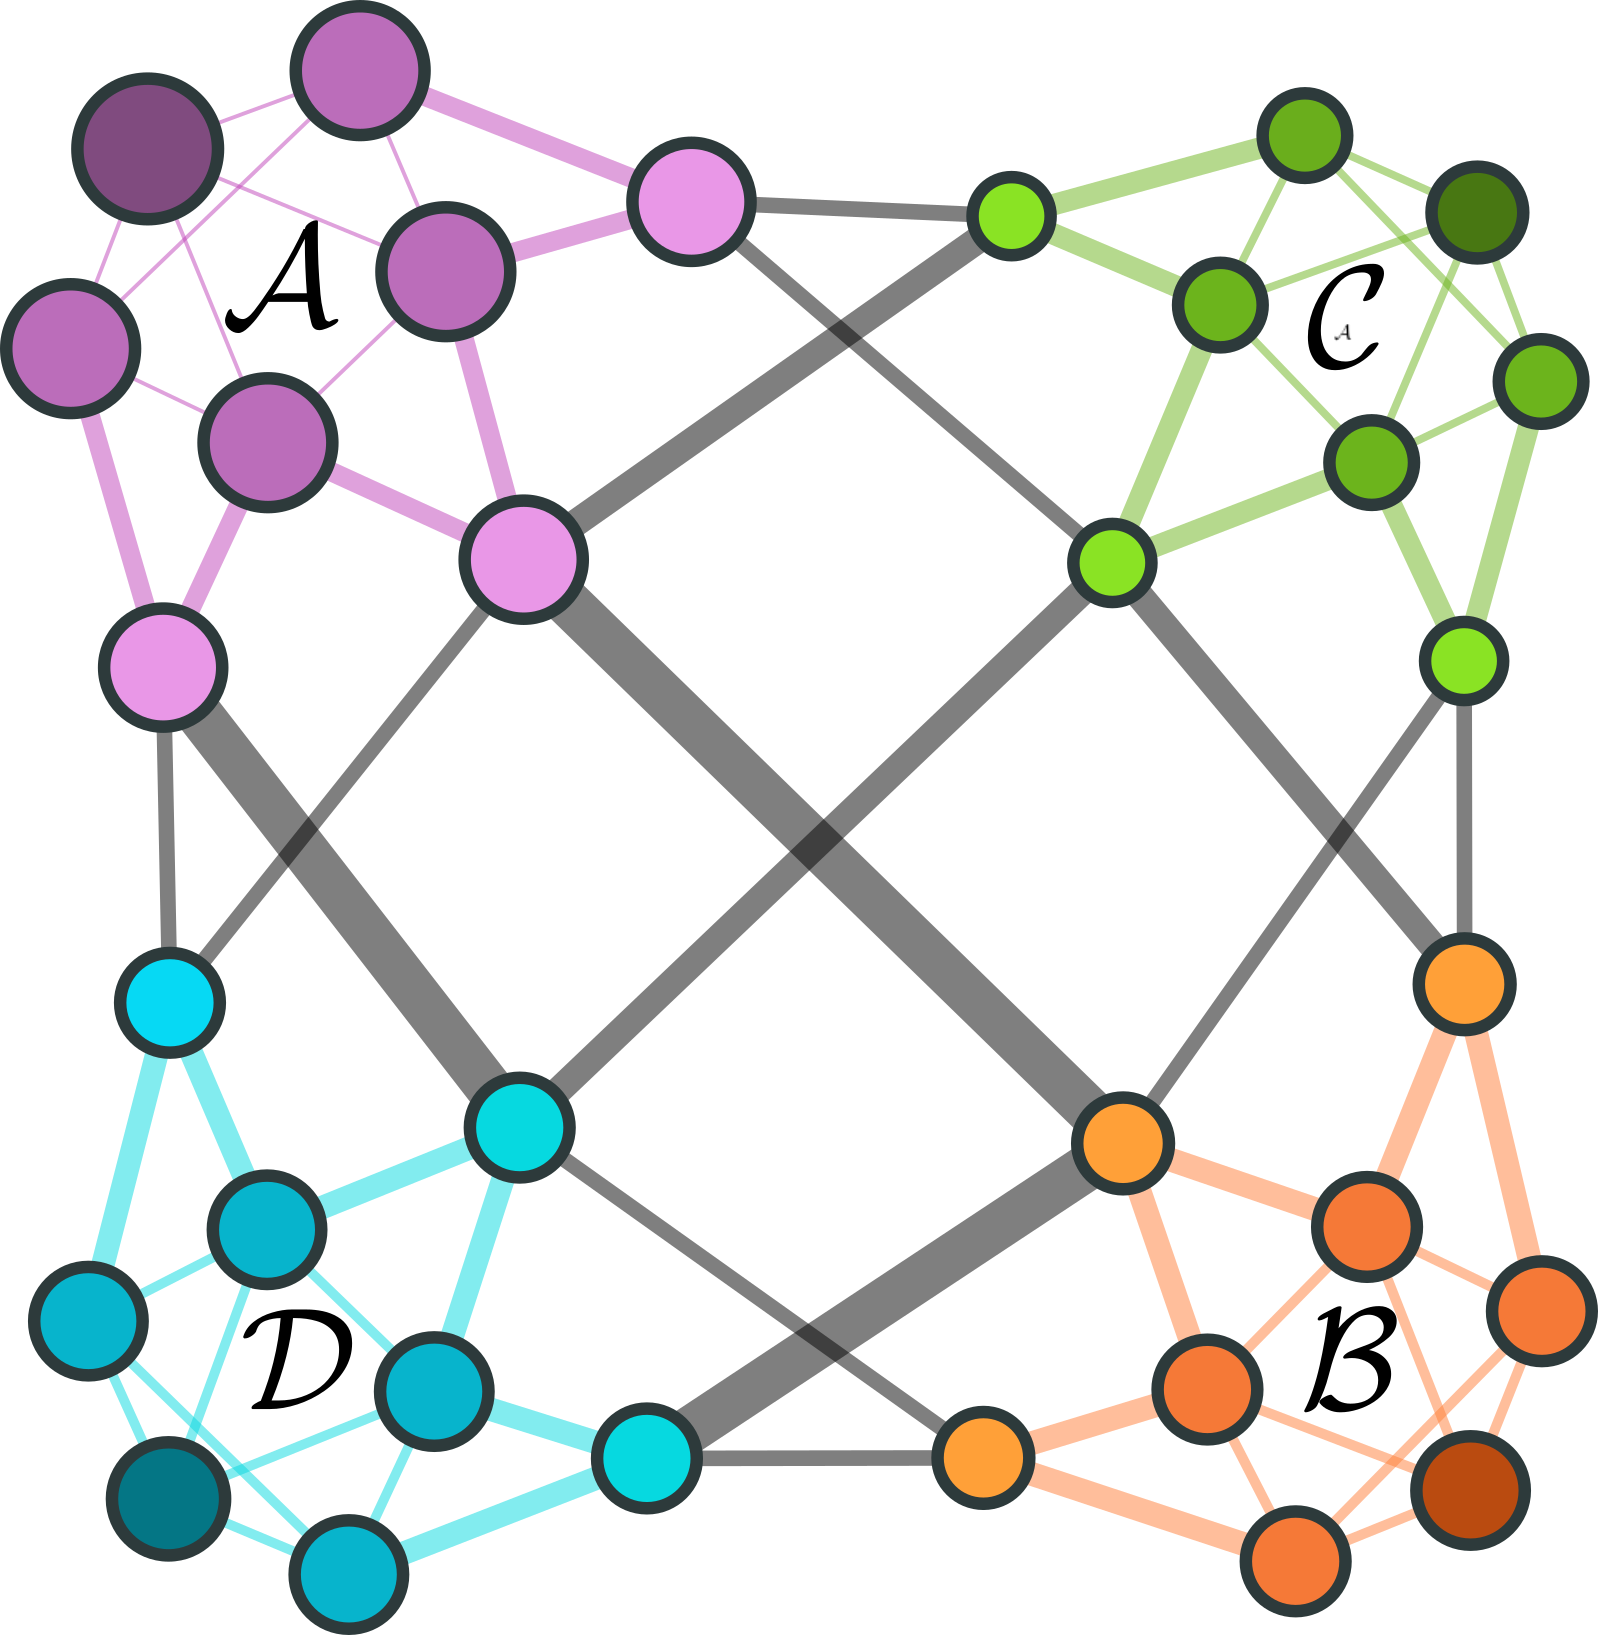

In [2]:
#Import library
from IPython.display import Image
Image(filename = "32state.png", width = 300)

## GT setup

Let's load in the Markov chain as well as its community structure. Community assignments are specified in a single-column file where each line contains the community ID of the node corresponding to the line number.

In [3]:
data_path = Path('KTN_data/32state')
temp = 10.0
beta = 1./temp
#GT setup
B, K, tau, N, u, s, Emin, index_sel = PyGT.io.load_ktn(path=data_path,beta=beta)
Q = K.todense() - np.diag(1.0/tau) #rate matrix with columns that sum to zero
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = PyGT.io.load_ktn_AB(data_path,index_sel) 
#Read in community structure
comms = PyGT.read_communities(data_path/'communities.dat', index_sel, screen=True)
for comm in comms:
    if np.all(comms[comm] == AS):
        print(f'Community A: {comm}')
    if np.all(comms[comm] == BS):
        print(f'Community B: {comm}')
#Compute MFPTs with GT for a range of temperatures
betas = 1./np.linspace(0.1, 10, 10)
df = PyGT.fpt_stats.rates_cycle(betas, data_path, fullGT=True)
df

Community 0: 8
Community 1: 8
Community 2: 8
Community 3: 8
Community A: 0
Community B: 3


,MFPTBA,MFPTAB,T
0,5.538914e+01,5.514380e+01,10.000000
0,1.088105e+03,9.284652e+02,0.833333
0,1.711334e+04,1.240028e+04,0.434783
0,2.971278e+05,1.875428e+05,0.294118
0,5.378579e+06,3.032633e+06,0.222222
0,9.883817e+07,5.110029e+07,0.178571
0,1.829787e+09,8.892823e+08,0.149254
0,3.406246e+10,1.590555e+10,0.128205
0,6.373748e+11,2.911342e+11,0.112360
0,1.198826e+13,5.430940e+12,0.100000


## Compute matrix of inter-microstate MFPTs with GT

The $32 \times 32$ matrix of inter-microstate MFPTs between all pairs of nodes can be used to obtain the optimal reduced coarse-grained Markov chain for a given community structure. Let's compute this matrix with GT and with two alternative linear algebra methods: eigendecomposition and inversion to obtain the fundamental matrix.

In [4]:
#compute matrix of inter-microstate MFPTs with GT
mfpt_gt, pi = PyGT.fpt_stats.get_intermicrostate_mfpts_GT(temp, data_path)
print(mfpt_gt.shape)
#check that the Kemeny constant is indeed constant
kemeny = pi@mfpt_gt
print(kemeny)
print("Kemeny constant from mfpts with GT: ", kemeny[0])

#compute matrix of inter-microstate MFPTs with fundamental matrix
ktn = Analyze_KTN(data_path, commdata='communities.dat')
ktn.K = Q
ktn.pi = pi
mfpt_fund = ktn.get_intermicrostate_mfpts_fundamental_matrix()
kemeny_fund = pi@mfpt_fund
print("Kemeny constant from mfpts with fundamental matrix: ", kemeny_fund[0])

#compute matrix of inter-microstate MFPTs with eigendecomposition
mfpt_eig = ktn.get_intermicrostate_mfpts_linear_solve()
kemeny_eig = pi@mfpt_eig
print("Kemeny constant from mfpts with eigendecomposition: ", kemeny_eig[0])


(32, 32)
[97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029
 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029
 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029 97.53002029]
Kemeny constant from mfpts with GT:  97.53002029348984
Kemeny constant from mfpts with fundamental matrix:  97.53002029348983
Kemeny constant from mfpts with eigendecomposition:  97.5300202934899


## Compute inter-community weighted-MFPTs

In [5]:
#compute weighted-MFPT between communities
commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
ktn.commpi = commpi
ncomms = len(commpi)
pt = ktn.get_intercommunity_weighted_MFPTs(pi, commpi, mfpt_gt)
#Kemeny constant of reduced Markov chain
print("Weighted-MFPT matrix:")
print(pt)
print("\n Kemeny constant of coarse-grained Markov chain")
print(commpi.T@pt)

Weighted-MFPT matrix:
[[ 0.         53.8206528  54.95852132 69.11554233]
 [53.00851035  0.         66.57240778 52.25954611]
 [54.71235842 67.13838734  0.         54.16914917]
 [69.93796797 53.8941142  55.2377377   0.        ]]

 Kemeny constant of coarse-grained Markov chain
[44.06002077 44.06002077 44.06002077 44.06002077]


## Different routes to obtain the optimal coarse-grained CTMC

In Kannan et al. *J. Chem. Phys.* (2020), we discuss three different expression for the optimal coarse-grained rate matrix given a partitioning of the $V$ nodes in the original Markov chain into $N$ communities: the HS relation, the KKRA relation, and an expression obtained from inverting the matrix of weighted-MFPTs. We illustrate the computation of all 3 methods below:

In [7]:
""" Three different version of the optimal reduced CTMC."""
#1) the original HS relation
K_hs = ktn.construct_coarse_rate_matrix_Hummer_Szabo(temp)

#2) the KKRA relation involving inversion of matrix of inter-microstate mfpts
K_kkra = ktn.construct_coarse_rate_matrix_KKRA(mfpt=mfpt_gt)

#3) based on inversion of weighted-MFPTs
K_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))

print('Optimal reduced CTMC from Hummer-Szabo relation:')
print(K_hs)
print('Optimal reduced CTMC from KKRA relation:')
print(K_kkra)
print('Optimal reduced CTMC from inversion of weighted-MFPT matrix:')
print(K_invert)

#check that Rhs has columns that sum to zero
print(K_invert.sum(axis=0))
#check that commpi is unique right eigenvector of Rhs with zero eigenvalue
print(K_invert@commpi)
#check that detailed balance is satisfied
if not PyGT.check_detailed_balance(commpi, K_invert):
    print('Detailed balance not satisfied for K_C.')
if not PyGT.check_detailed_balance(pi, Q):
    print('Detailed balance not satisfied for K')

Optimal reduced CTMC from Hummer-Szabo relation:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]
Optimal reduced CTMC from KKRA relation:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]
Optimal reduced CTMC from inversion of weighted-MFPT matrix:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]
[-2.77555756e-17  1.73472348e-17  3.46944695e-17 -4.16333634e-17]
[-1.73472348e-18 -1.73472348e-18  0.00000000e+00 -8.67361738e-19]


## Numerical comparison of coarse-grained Markov chains

To compare the numerical stability of these various routes to obtain the optimal reduced CTMC, let's compute the mean first passage times $\mathcal{A} \leftrightarrow \mathcal{B}$ on the original network and compare it to the corresponding observables on the various reduced networks.

In [14]:
def compare_HS_LEA(temps, data_path=Path('KTN_data/32state')):
    """ Calculate coarse-grained rate matrices using the 3 versions of the optimal
    reudced Markov chain and the local equilibrium approximation (LEA).
    Compute MFPTAB/BA on the full and coarse-grained networks. """

    dfs = []
    for temp in temps:
        df = pd.DataFrame()
        df['T'] = [temp]
        ktn = Analyze_KTN(data_path, commdata='communities.dat')
        #KTN input
        beta = 1./temp
        B, K, tau, N, u, s, Emin, index_sel = PyGT.io.load_ktn(path=data_path,beta=beta,screen=True)
        
        Q = K.todense() - np.diag(1.0/tau)
        AS, BS = PyGT.io.load_ktn_AB(data_path,index_sel) 
        D = np.ravel(K.sum(axis=0))
        BF = beta*u-s
        BF -= BF.min()
        pi = np.exp(-BF)
        pi /= pi.sum()
        #ktn setup
        commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
        ktn.K = Q
        ktn.pi = pi
        ktn.commpi = commpi
        ncomms = len(commpi)
        #MFPT calculations on full network
        full_df = PyGT.fpt_stats.compute_rates(AS, BS, B, escape_rates=D, K=K, BF=BF, fullGT=True)
        df['MFPTAB'] = full_df['MFPTAB']
        df['MFPTBA'] = full_df['MFPTBA']
        
        #compute coarse-grained networks
        mfpt, pi = PyGT.fpt_stats.get_intermicrostate_mfpts_GT(temp, data_path)
        pt = ktn.get_intercommunity_weighted_MFPTs(pi, commpi, mfpt)
        labels = []
        matrices = []
        try:
            Rhs = ktn.construct_coarse_rate_matrix_Hummer_Szabo()
            matrices.append(Rhs)
            labels.append('HS')
        except Exception as e:
            print(f'HS had the following error: {e}')
        try:
            Rhs_kkra = ktn.construct_coarse_rate_matrix_KKRA(mfpt=mfpt)
            matrices.append(Rhs_kkra)
            labels.append('KKRA')
        except Exception as e:
            print(f'KKRA had the following error: {e}')
        try:
            Rhs_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))
            matrices.append(Rhs_invert)
            labels.append('PTinvert_GT')
        except Exception as e:
            print(f'Inversion of weighted-MFPTs from GT had the following error: {e}')
        try:
            Rlea = ktn.construct_coarse_rate_matrix_LEA(temp)
            matrices.append(Rlea)
            labels.append('LEA')
        except Exception as e:
            print(f'LEA had the following error: {e}')

        if len(matrices)==0:
            continue

        for i, R in enumerate(matrices):
            """ get A->B and B->A mfpt on coarse network"""
            rK = R - np.diag(np.diag(R))
            escape_rates = -1*np.diag(R)
            B = rK@np.diag(1./escape_rates)
            Acomm = 0
            Bcomm = 3
            MFPTAB, MFPTBA = PyGT.fpt_stats.compute_MFPTAB(Acomm, Bcomm, B, escape_rates=escape_rates, K=rK)
            df[f'AB_{labels[i]}'] = [MFPTAB]
            df[f'BA_{labels[i]}'] = [MFPTBA]
        dfs.append(df)
    bigdf = pd.concat(dfs, ignore_index=True, sort=False)
    return bigdf

In [17]:
#some mid temperature calculations
invtemps = np.linspace(2, 3, 12)
midtemp_df = compare_HS_LEA(1./invtemps, data_path=Path('KTN_data/32state'))


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes


	Connected Clusters

In [15]:
def plot_mfpts_32state(df):
    """Plot MFPTs computed on coarse-grained networks against true MFPT from full network."""
    colors = sns.color_palette("Dark2", 4)
    df.replace([np.inf, -np.inf], np.nan)
    df2= df.sort_values('T')
    symbols = ['-s', '--o', '-o', '--^']
    rates = ['LEA', 'PTinvert_GT', 'KKRA', 'HS']
    labels = rates
    denom = 'MFPT'
    #first plot A<-B direction
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    ax.plot(1./df2['T'], df2['MFPTBA'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'BA_{CG}'].isna()]
        ax.plot(1./df2CG['T'], df2CG[f'BA_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax.set_xlabel(r'$1/T$')
    ax.set_yscale('log')
    ax.set_ylabel('MFPTBA')
    ax.legend(frameon=True)
    ax2.plot(1./df2['T'], df2['MFPTAB'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'AB_{CG}'].isna()]
        ax2.plot(1./df2CG['T'], df2CG[f'AB_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax2.set_xlabel(r'$1/T$')
    ax2.set_ylabel('MFPTAB')
    ax2.set_yscale('log')
    ax2.legend(frameon=True)
    fig.tight_layout()

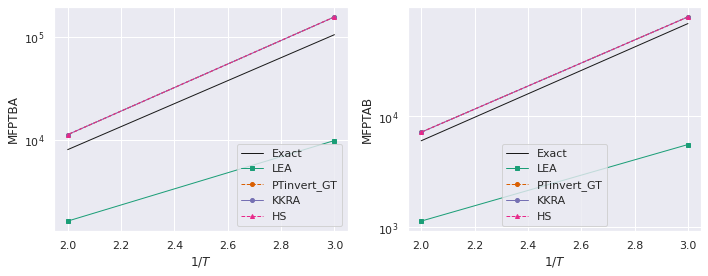

In [16]:
plot_mfpts_32state(midtemp_df)